# Einführung

Seamless Cloning (nahtlose Klonierung) ist der Prozess, einen Bild oder Bildausschnitt an einem anderen Bild einzufügen, sodass die Farbe der Bilder übereinstimmt und natürlich (nahtlos) aussieht.  

Dieser Code ist eine Implementation der genannten nahtlosen Klonierung durch diskrete Differentialoperatoren. Da ein Bild nur ein 2D Array mit Farbwert auf jeden Index, die Werte des Hintergrundbildes können manipuliert werden, sodass das gewünschte Bild sich manifestiert. Die Grundidee ist, die 'Änderung der Pixel' oder die Gradienten von dem Originalbild zu kopieren und auf das Hintergrundbild anzuwenden, während die tatsächlichen Farbwerte an dem Rand beibehalten werden. Das erlaubt die 'Form' des Originalbildes auf dem Hintergrundbild zu erscheinen. 

Der ganze Prozess besteht aus nur zwei Schritten: 
1. Bildbearbeitung
2. Bildausgabe

Die Bearbeitung braucht jedoch mehrere Hilfsfunktionen und relativ tiefgreifende mathematische Techniken, da die Implementierung nur minimale Hilfe von externen Paketen nutzt. Zusätzliche Erklärungen zu den einzelnen Funktionen kann man in den jeweiligen Unterabschnitten finden. 

# Packages

In [3]:
import numpy as np
import scipy
import matplotlib
import skimage
from scipy import sparse
from scipy.sparse.linalg import cg
from skimage import io
from skimage import data
from matplotlib import pyplot as plt

# Seamless Cloning

Zwei Versionen von nahtloser Klonierung werden implementiert: mit Laplace-Operator und mit gemischten Gradienten. In beiden Fällen ist das Ziel, die Gleichung Δ(f) = Δ(g) (Poissongleichung) zu lösen, wobei f und g die Matrizenformen der Original- und Hintergrundbild und Δ der Laplace-Operator sind. 
* Mit Laplace-Operator: zerlegt das importierte Bild in 3 Fabwerte (g1, g2, g3, f1, f2, f3) und löst die Poissongleichung für je Farbwert. Die neuen Werte ersetzen dann den Zielausschnitt des Hintergrundbildes f, dessen Grenzen mit i und j bezeichnet.
* Mit gemischten Gradienten: die gemischten Gradienten sind ein diskretes Vektorfeld, dessen Werte aus dem höheren Wert zwischen ∇f und ∇g (Gradienten der jeweiligen Funktionen) entnommen werden. Dies verhindert Verschwimmung der Farben, wenn sich die deutlicheren Teile des Bildes überlappen, und erzeugt ein klareres Ergebnis (siehe Beispielbilder). 

In [4]:
def seamlessg(f, g, i, j): #Seamless cloning with laplace operator
    n = len(g)
    m = len(g[0]) 
    #separate pixel values to each rgb value for target image and background image 
    g1 = g[:,:,0]
    f1 = f[i:i+n, j:j+m, 0]
    g2 = g[:,:,1]
    f2 = f[i:i+n, j:j+m, 1]
    g3 = g[:,:,2]
    f3 = f[i:i+n, j:j+m, 2]
    #extract boundary values from background image
    rand1 = randextract(f1)
    rand2 = randextract(f2)
    rand3 = randextract(f3)
    #compute solutions to the Poisson equations 
    new1 = vecPG1(g1, rand1)
    new2 = vecPG1(g2, rand2) 
    new3 = vecPG1(g3, rand3)
    #stack the values again for proper color value 
    result = np.dstack((new1, new2, new3))
    f[i:i+n, j:j+m] = result 
    return f 

def seamlessv(f, g, i, j): #Seamless cloning with mixed gradients
    n = len(g)
    m = len(g[0]) 
    #separate pixel values to each rgb value for target image and background image 
    g1 = g[:,:,0]
    f1 = f[i:i+n, j:j+m, 0]
    g2 = g[:,:,1]
    f2 = f[i:i+n, j:j+m, 1]
    g3 = g[:,:,2]
    f3 = f[i:i+n, j:j+m, 2]
    #extract boundary values from background image
    rand1 = randextract(f1)
    rand2 = randextract(f2)
    rand3 = randextract(f3)
    #obtain mixed gradient vector field  
    divV1 = divV(f1, g1)
    divV2 = divV(f2, g2)
    divV3 = divV(f3, g3) 
    #compute solutions to the Poisson equations 
    new1 = vecPG2(divV1, rand1)
    new2 = vecPG2(divV2, rand2) 
    new3 = vecPG2(divV3, rand3)
    #stack the values again for proper color value 
    result = np.dstack((new1, new2, new3))
    f[i:i+n, j:j+m] = result 
    return f

# Poissongleichung

Die Poissongleichung ist durch Δ(f) = Δ(g) definiert, wobei Δ der Laplace-Operator ist. Das Ziel dieser Funktionen ist, ein lineares Gleichungssystem der Form Ax = b zu konstruieren, mit A der diskrete Laplace-Operator und b die vektorielle Divergenz von g (oder V) ist, also das zu kopierende Bild. vecPG2 soll für gemischte Gradienten verwendet werden, die bereits aus einer Divergenz von f oder g bestehen, und daher muss das gegebene V nur abgeflacht werden.

In [10]:
def vecPG1(g, rand):
    n = len(g)
    m = len(g[0])
    index = randboolean(n, m)
    A = LO(n, m)
    vecg = np.ndarray.flatten(np.transpose(g))
    vecrand = np.ndarray.flatten(np.transpose(rand))
    b1 = sparse.csr_matrix.dot(A, vecg)
    b2 = sparse.csr_matrix.dot(A, vecrand)
    b = np.subtract(b1, b2)[index]
    #exclude boundaries 
    A = A[index, :]
    A = A[:, index]
    #solve the system of Ax = b, then round its values 
    result1 = scipy.sparse.linalg.cg(A, b, rtol = 1e-07)[0]   
    result1 = np.rint(result1)
    #change values to 0 if negative and 255 if over 
    for i in range(0, (n-2) * (m-2)):
        if result1[i] < 0:
            result1[i] = 0
        elif result1[i] > 255:
            result1[i] = 255
    result1 = result1.reshape(m-2, n-2)
    result1 = np.transpose(result1)
    result = rand
    result[1:n-1, 1:m-1] = result1
    return result

def vecPG2(V, rand):
    n = len(V)
    m = len(V[0])
    index = randboolean(n, m) 
    A = LO(n, m)
    vecV = np.ndarray.flatten(np.transpose(V))
    vecrand = np.ndarray.flatten(np.transpose(rand))
    b = np.subtract(vecV, sparse.csr_matrix.dot(A, vecrand))[index]
    #exclude boundaries 
    A = A.tocsr()[index, :]
    A = A.tocsr()[:, index]
    #solve the system of Ax = b, then round its values 
    result1 = scipy.sparse.linalg.cg(A, b, rtol = 1e-07)[0]
    result1 = np.rint(result1)
    #change values to 0 if negative and 255 if over 
    for i in range(0, (n-2) * (m-2)):
        if result1[i] < 0:
            result1[i] = 0
        elif result1[i] > 255:
            result1[i] = 255
    result1 = result1.reshape(m-2, n-2)
    result1 = np.transpose(result1)
    result = rand
    result[1:n-1, 1:m-1] = result1
    return result

# Hilfsfunktionen: diskrete Differentialoperatoren

Das mathematische Konzept dieser Implementation ist diskrete Gradienten, und es braucht mehrere Hilfsfunktionen, die die gewünschten Rollen spielen: 
* Laplace-Operator: erzeugt eine nmXnm-Matrix, die den diskreten Laplace-Operator darstellt. Der Laplace-Operator einer Funktion (Matrix in diesem Fall) f kann durch Dn⊗f + f⊗Dn diskretisiert werden, wobei Dn die Matrixdarstellung von diskreter zweiten Ableitung und ⊗ das Kronecker-Produkt ist. Dieser Code ersetzt die Funktion f durch Identitätsmatrizen In und Im. 
* Diskrete 2. Ableitung: erzeugt eine nXn-Matrix Dn mit -2 auf ihrer Diagonale und 1 auf ihren Unter-/Superdiagonaleinträge. Diese Matrix ist analog zur diskreten 2. Ableitung: u'' = Dn x u. 
* Divergenz: erzeugt die diskrete Rückwärtsdivergenz unter Verwendung der beiden gegebenen Matrizen f und g. Ein Vektorfeld v wird konstruiert, indem der maximale Wert zwischen f und g gewählt wird. Da eine Matrix ein 2D Array ist, werden die Differenzen für beide Achsen (x und y) berechnet und dann summiert (da die Divergenz ein Skalarwert ist). 
* Diskreter Gradient: erzeugt den diskreten Vorwärtsgradient der Matrix f. Wie die Divergenz wird auch der Gradient für beide Achsen (x und y) berechnet und als Vektor zusammengestellt (da der Gradient ein Vektorfeld ist). 
* Vorwärts- und Rückwärtsdifferenzen: erzeugen nXn-Matrizen mit -1 auf der Diagonaleinträge und 1 auf der Superdiagonaleinträge bzw. 1 auf der Diagonaleinträge und -1 auf der Unterdiagonaleinträge. Diese Matrizen werden verwendet, um die Wertedifferenz zwischen einem Element und seinen nächsten/vorherigen Elementen für einen Abschnitt statt eines Skalarwerts zu berechnen.

In [6]:
def LO(n, m): #Laplace operator 
    In = scipy.sparse.identity(n) 
    Im = scipy.sparse.identity(m) 
    Dn = discrete(n)
    Dm = discrete(m) 
    X1 = sparse.csr_matrix(Dn)
    X = sparse.kron(Im, X1)
    Y1 = sparse.csr_matrix(Dm)
    Y = sparse.kron(Y1, In)
    return (X + Y).tocsr()

def discrete(n): #discrete 2nd derivative 
    result = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            if i == j:
                result[i, j] = -2
            elif i == j - 1:
                result[i, j] = 1
            elif i == j + 1:
                result[i, j] = 1
    return result

def divV(f, g): #divergence 
    n = len(f)
    m = len(f[0]) 
    V1 = np.zeros((n, m))
    V2 = np.zeros((n, m))
    vorf = vorgrad(f)
    vorg = vorgrad(g) 
    #constructing vector field. The greater value between norm of f and norm of g is always chosen. 
    for k in range(0, n):
        for l in range(0, m):
            #euclidean norm 
            normf = vorf[k, l][0]**2 + vorf[k, l][1]**2
            normg = vorg[k, l][0]**2 + vorg[k, l][1]**2
            if normf > normg:
                V1[k, l] = vorf[k, l][0]
                V2[k, l] = vorf[k, l][1]
            else:
                V1[k, l] = vorg[k, l][0]
                V2[k, l] = vorg[k, l][1]
    Dn = ruckdiff(n)
    Dm = np.transpose(ruckdiff(m)) 
    result = np.matmul(Dn, V1) + np.matmul(V2, Dm)
    return result
            
def vorgrad(f): #discrete gradient 
    n = len(f)
    m = len(f[0])
    Dn = vordiff(n)
    Dm = np.transpose(vordiff(m))
    #vertical gradient
    first = np.matmul(Dn, f)
    #horizontal gradient 
    second = np.matmul(f, Dm)
    result = np.dstack((first, second))
    return result

def vordiff(n): #forward difference 
    result = -np.identity(n)
    for i in range(0, n-1):
        result[i, i+1] = 1
    return result

def ruckdiff(n): #backward difference 
    result = np.identity(n)
    for i in range(0, n-1):
        result[i+1, i] = -1
    return result

# Andere Hilfsfunktionen

* randextract: extrahiert die Randwerte der gegebenen Matrix f. 
* randboolean: generiert eine boolesche List mit True für Werte, die nicht am Rand liegen. Kein 2D Array, aber eine 1D Liste. 

In [7]:
def randextract(f): #boundary values
    n = len(f)
    m = len(f[0])
    result = np.zeros((n, m))
    result += f 
    for k in range(0, n):
        for l in range(0, m):
            if k in range(1, n-1) and l in range(1, m-1):
                result[k, l] = 0
    return result 

def randboolean(n, m): #boundary boolean
    index = [i for i in range(n-1, -1, -1)]
    result = []
    for i in range(1, m-1):
        index.insert(0, i*n)
        index.insert(0, (i+1)*n - 1)
    for i in range((m-1)*n, m*n):
        index.insert(0, i)
    for i in range(0, n*m):
        if i in index:
            result.append(False)
        else:
            result.append(True) 
    return result
    #example: randboolean(3, 3) = [False, False, False, False, True, False, False, False, False]

# Bildausgabe

In [8]:
def plotten(f,g,i,j):
    f1 = np.copy(f)
    f2 = np.copy(f)
    f3 = np.copy(f)
    n = len(g)
    m = len(g[0])
    f1[i:i+n, j:j+m] = g
    a = seamlessg(f2,g,i,j)
    b = seamlessv(f3,g,i,j)
    f, axarr = plt.subplots(nrows=1,ncols=3,figsize=(50, 25))
    plt.sca(axarr[0]); 
    plt.imshow(f1, cmap='gray'); plt.title('Ohne Seamless-Cloning'); plt.axis('off')
    plt.sca(axarr[1]); 
    plt.imshow(a, cmap='gray'); plt.title('Seamless-Cloning mit Laplace-Operator'); plt.axis('off')
    plt.sca(axarr[2]); 
    plt.imshow(b, cmap='gray'); plt.title('Seamless-Cloning mit gemischten Gradienten'); plt.axis('off')
    plt.show()

# Beispiele

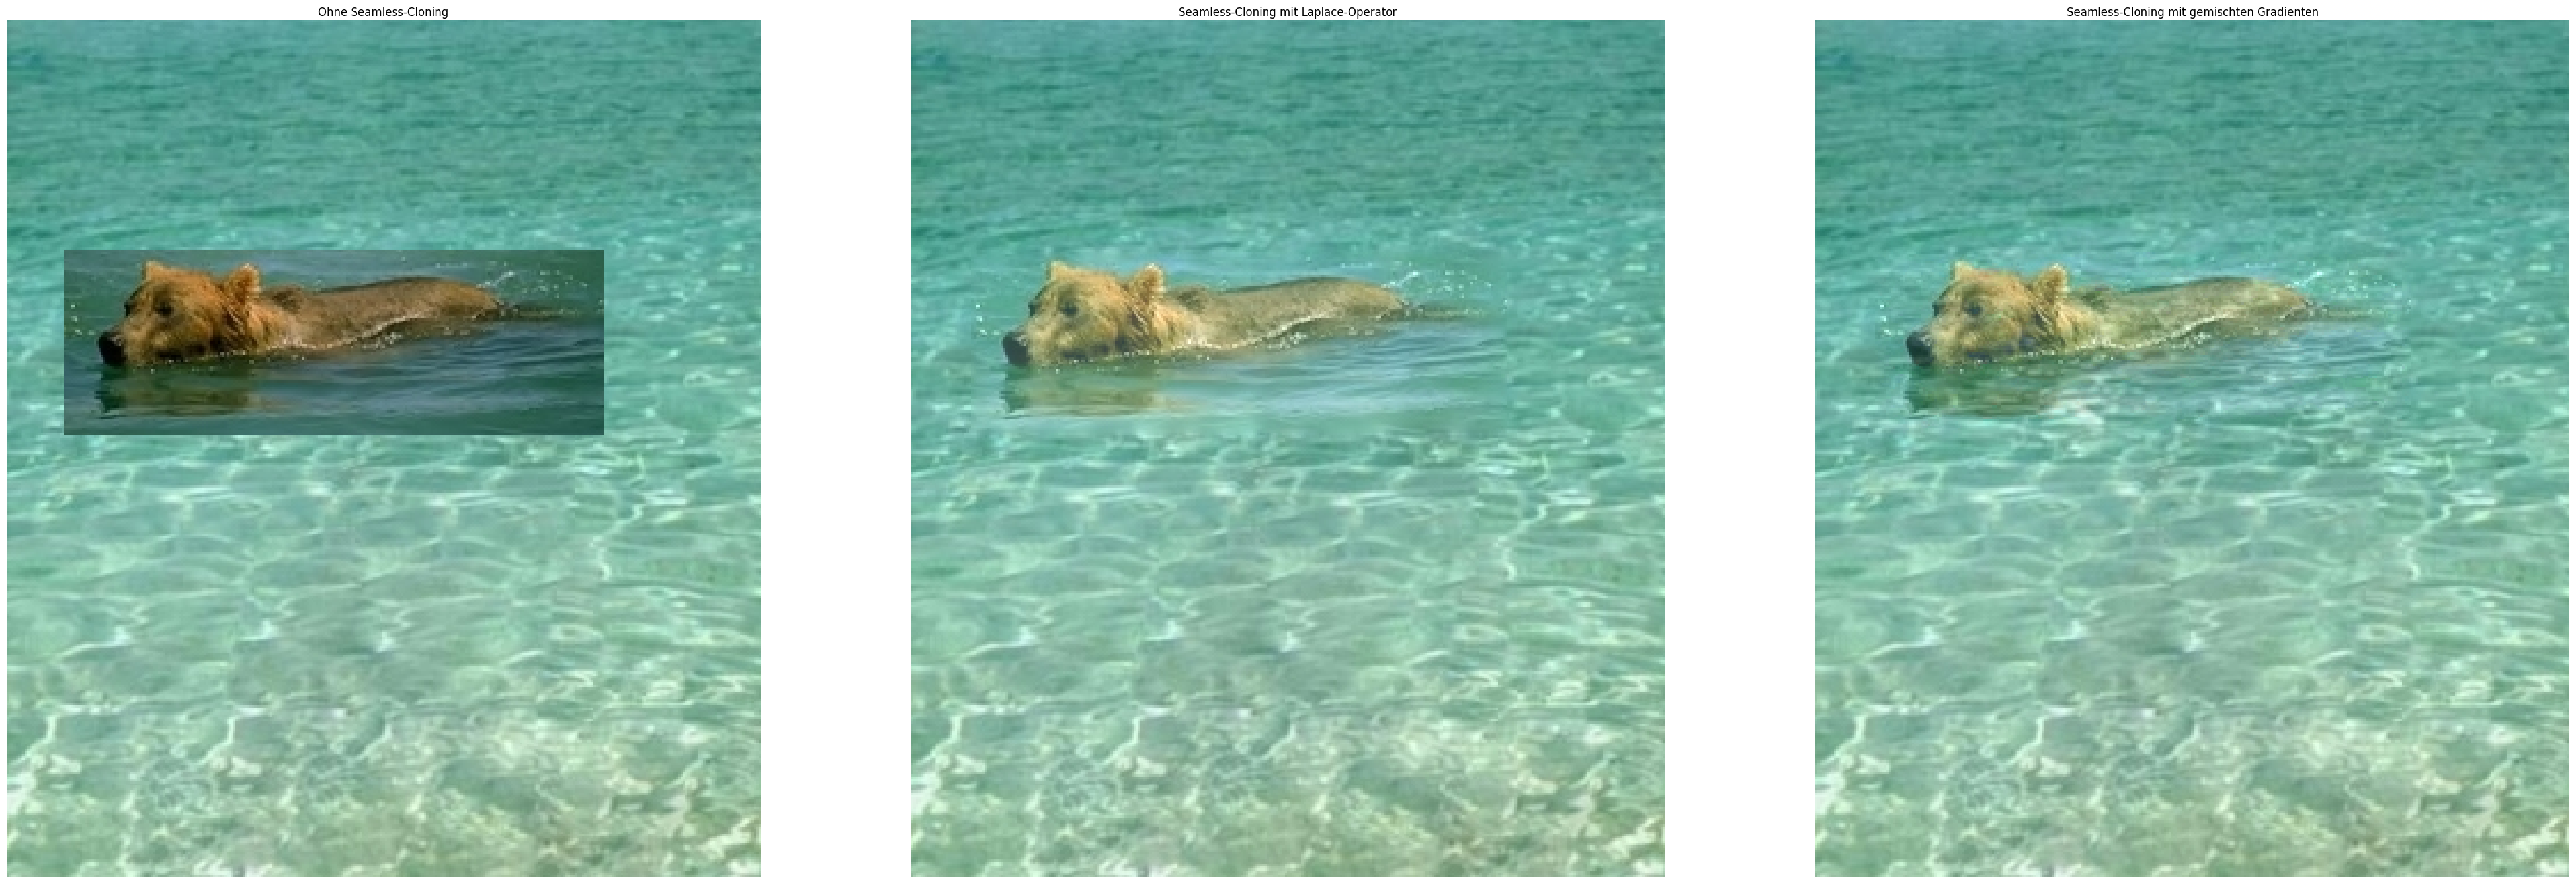

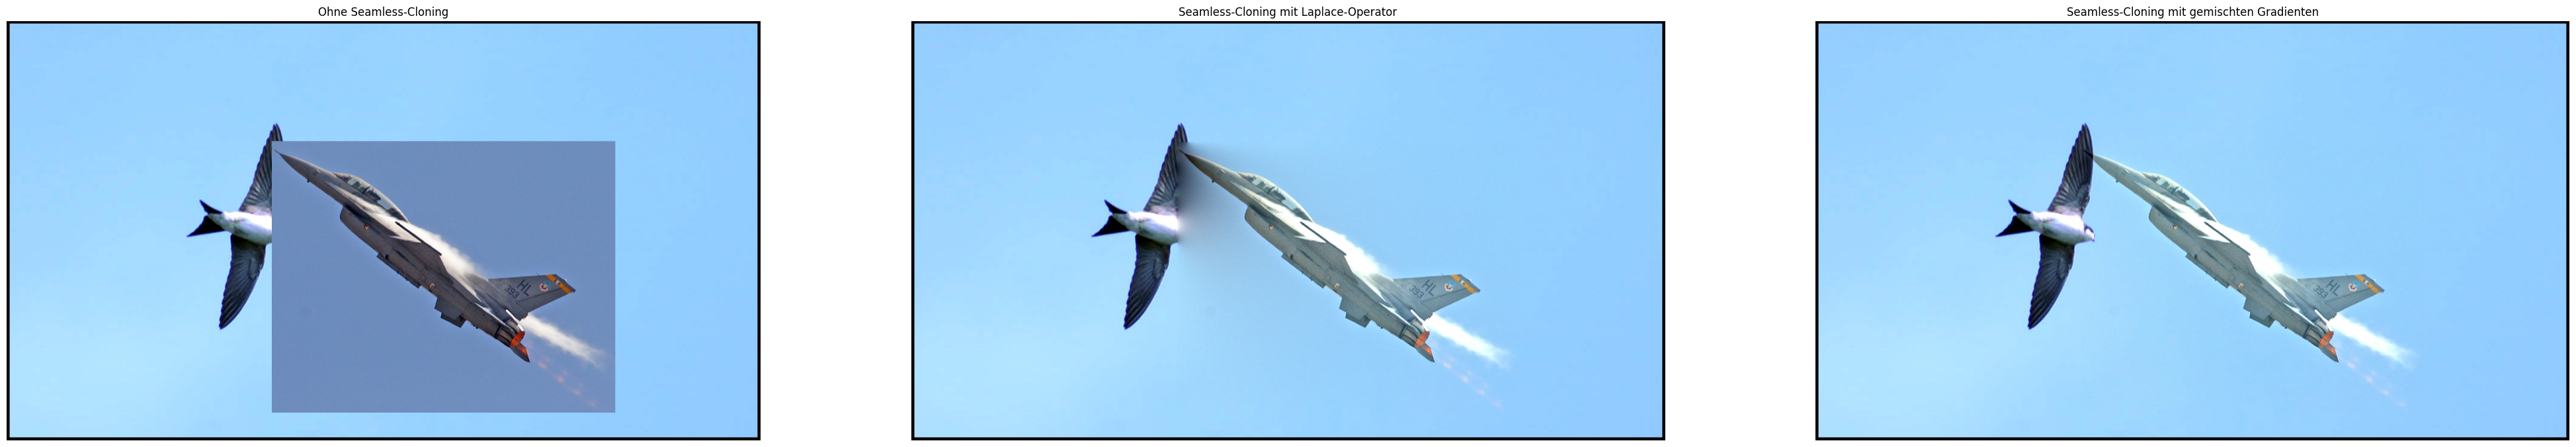

In [11]:
bear = skimage.io.imread("bear.jpg")
bear2 = bear[50:131, 24:260]
water = skimage.io.imread("water.jpg")
plotten(water, bear2, 100, 25)

plane = skimage.io.imread("plane.jpg")
plane2 = plane[100:550,180:750] 
bird = skimage.io.imread("bird.jpg")
plotten(bird, plane2, 200, 440)